In [1]:
import orekit
from orekit.pyhelpers import setup_orekit_curdir, download_orekit_data_curdir

download_orekit_data_curdir()
orekit.initVM()
setup_orekit_curdir()

In [79]:
from org.orekit.propagation.analytical import BrouwerLyddanePropagator, KeplerianPropagator
from org.orekit.propagation import PropagationType
from org.orekit.orbits import KeplerianOrbit, PositionAngle
from org.orekit.time import AbsoluteDate, TimeScalesFactory
from org.orekit.bodies import CelestialBodyFactory
from org.orekit.utils import Constants
from org.orekit.frames import FramesFactory
from org.orekit.attitudes import NadirPointing
from org.orekit.bodies import OneAxisEllipsoid
from org.orekit.models.earth import ReferenceEllipsoid
from org.orekit.orbits import OrbitType
from org.orekit.utils import Constants
import matplotlib.pyplot as plt

import math

In [102]:
# create a keplerian orbit for a satellite at 400km, 600km, and 800km altitude
initialDate = AbsoluteDate(2023, 1, 1, 12, 0, 0.0, TimeScalesFactory.getUTC())
mu = Constants.WGS84_EARTH_MU
inertialFrame = FramesFactory.getICRF()
orbits = [KeplerianOrbit(6771.7e3, 0.0007, 51.64 * 3.14/180, math.radians(13.8511), math.radians(21.3671), math.radians(98.5566), PositionAngle.MEAN, inertialFrame, initialDate, mu),
 KeplerianOrbit(7771.7e3, 0.0007, 51.64 * 3.14/180, math.radians(13.8511), math.radians(21.3671), math.radians(98.5566), PositionAngle.MEAN, inertialFrame, initialDate, mu),
 KeplerianOrbit(8771.7e3, 0.0007, 51.64 * 3.14/180, math.radians(13.8511), math.radians(21.3671), math.radians(98.5566), PositionAngle.MEAN, inertialFrame, initialDate, mu),
 KeplerianOrbit(9771.7e3, 0.0007, 51.64 * 3.14/180, math.radians(13.8511), math.radians(21.3671), math.radians(98.5566), PositionAngle.MEAN, inertialFrame, initialDate, mu),
 KeplerianOrbit(10771.7e3, 0.0007, 51.64 * 3.14/180, math.radians(13.8511), math.radians(21.3671), math.radians(98.5566), PositionAngle.MEAN, inertialFrame, initialDate, mu)]

JavaError: <super: <class 'JavaError'>, <JavaError object>>
    Java stacktrace:
org.orekit.errors.OrekitException: unable to compute Brouwer-Lyddane mean parameters after 201 iterations
	at org.orekit.propagation.analytical.BrouwerLyddanePropagator.computeMeanParameters(BrouwerLyddanePropagator.java:776)
	at org.orekit.propagation.analytical.BrouwerLyddanePropagator.resetInitialState(BrouwerLyddanePropagator.java:680)
	at org.orekit.propagation.analytical.BrouwerLyddanePropagator.<init>(BrouwerLyddanePropagator.java:531)
	at org.orekit.propagation.analytical.BrouwerLyddanePropagator.<init>(BrouwerLyddanePropagator.java:475)


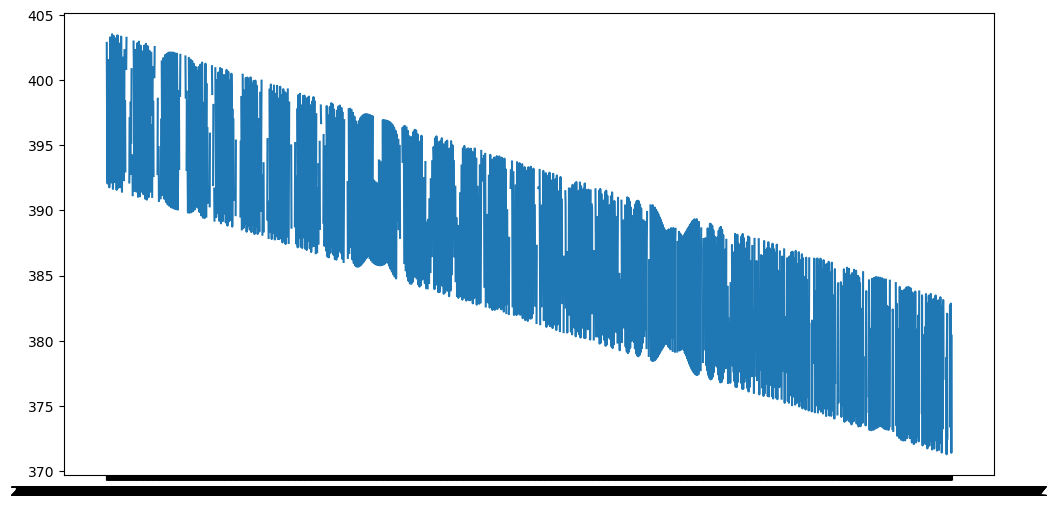

In [126]:
# create a keplerian orbit for a satellite at 400km, 600km, and 800km altitude
initialDate = AbsoluteDate(2023, 1, 1, 12, 0, 0.0, TimeScalesFactory.getUTC())
mu = Constants.WGS84_EARTH_MU
inertialFrame = FramesFactory.getICRF()
orbits = [KeplerianOrbit(6771.7e3, 0.0007, 51.64 * 3.14/180, math.radians(13.8511), math.radians(21.3671), math.radians(98.5566), PositionAngle.MEAN, inertialFrame, initialDate, mu),
 KeplerianOrbit(6780.7e3, 0.0007, 90.64 * 3.14/180, math.radians(13.8511), math.radians(21.3671), math.radians(98.5566), PositionAngle.MEAN, inertialFrame, initialDate, mu),
 KeplerianOrbit(6800.7e3, 0.0007, 90.64 * 3.14/180, math.radians(13.8511), math.radians(21.3671), math.radians(98.5566), PositionAngle.MEAN, inertialFrame, initialDate, mu),
 KeplerianOrbit(6900.7e3, 0.0007, 90.64 * 3.14/180, math.radians(13.8511), math.radians(21.3671), math.radians(98.5566), PositionAngle.MEAN, inertialFrame, initialDate, mu),
 KeplerianOrbit(7000.7e3, 0.0007, 90.64 * 3.14/180, math.radians(13.8511), math.radians(21.3671), math.radians(98.5566), PositionAngle.MEAN, inertialFrame, initialDate, mu)]

# Use NadirPointing as the AttitudeProvider (points towards Earth center)
body = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                        Constants.WGS84_EARTH_FLATTENING, 
                        inertialFrame)
attitudeProvider = NadirPointing(inertialFrame, body)

# Brouwer-Lyddane Propagator parameters
mass = 100.0  # arbitrary satellite mass in kg
referenceRadius = Constants.WGS84_EARTH_EQUATORIAL_RADIUS
c20 = -1.08e-3  # un-normalized zonal coefficient
c30 = 2.53e-6   # un-normalized zonal coefficient
c40 = 1.62e-6   # un-normalized zonal coefficient
c50 = 2.28e-7   # un-normalized zonal coefficient
M2 = 1.0e-14 # ignoring empirical drag

#propagator = BrouwerLyddanePropagator(orbits[3], attitudeProvider, mass, referenceRadius, mu, c20, c30, c40, c50, PropagationType, M2)

# Build a keplerian propagator for comparison
#propagator = KeplerianPropagator(initialOrbit)

days = 3000
dates = []

for day in range(1, days):
    finalDate = initialDate.shiftedBy(86400.0 * day)
    dates.append(finalDate.toString())

plt.figure(figsize=(12, 6))

# Propagate each satellite and plot its altitude
for orbit in orbits:
    altitudes = []
    propagator = BrouwerLyddanePropagator(orbit, attitudeProvider, mass, referenceRadius, mu, c20, c30, c40, c50, PropagationType.OSCULATING, M2)
    for day in range(1, days):
        try: 
            propagatedOrbit = propagator.propagate(initialDate.shiftedBy(86400.0 * day))
            altitude = propagatedOrbit.getA() - Constants.WGS84_EARTH_EQUATORIAL_RADIUS
            altitudes.append(altitude/1000)  # in km
        except:
            altitudes.append(None)  # if propagation failed
    plt.plot(dates, altitudes, label=f'Altitude: {orbit.getA()/1e3 - 6378.0} km')

plt.xticks(dates[::30])  # display every 30th date for readability
plt.xlabel('Date')
plt.ylabel('Altitude (km)')
plt.title('Altitude over Time for Various Satellites')
plt.grid(True)
plt.tight_layout()
# plt.legend()
# plt.ylim(0, 500)
plt.xticks(rotation=45)
plt.show()

In [64]:
altitudes

[398.8625413433984]